In [5]:
import random
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import wandb
from google.colab import files
from torch.utils.data import DataLoader

uploaded = files.upload()

project_root = Path.cwd()
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from musicagent.config import DataConfig, OnlineConfig
from musicagent.data import OnlineDataset, make_online_collate_fn

# Evaluation utilities
from musicagent.eval import (
    chord_length_entropy,
    chord_lengths,
    decode_tokens,
    note_in_chord_at_beat,
    note_in_chord_ratio,
    onset_interval_emd,
    onset_intervals,
)
from musicagent.models import OnlineTransformer


In [6]:
%cd /content/models

wandb.login()
ARTIFACT_REF = "marty1ai/musicagent/best-online-model:v43"

CHECKPOINT_DIR = Path("checkpoints")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

api = wandb.Api()
artifact = api.artifact(ARTIFACT_REF, type="model")
artifact_dir = Path(artifact.download(root=str(CHECKPOINT_DIR)))

pt_files = list(artifact_dir.rglob("*.pt"))
CHECKPOINT_PATH = pt_files[0]
print(CHECKPOINT_PATH)

/content/models


wandb: Downloading large artifact 'best-online-model:v43', 147.98MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:00.3 (510.5MB/s)


checkpoints/best_model.pt


In [7]:
# Evaluation config
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAMPLE = False
TEMPERATURE = 1.0

# Use default configs (model was trained with defaults)
d_cfg = DataConfig()
m_cfg = OnlineConfig()
m_cfg.device = DEVICE
device = torch.device(m_cfg.device)
print(f"Device: {device}")

# Use OnlineDataset - filters zero-frame sequences and provides correct interleaved format
test_ds = OnlineDataset(d_cfg, split="test")
collate_fn = make_online_collate_fn(pad_id=d_cfg.pad_id)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)

# Vocab mappings for decoding
# OnlineDataset uses unified vocab: melody [0, melody_vocab_size), chord offset by melody_vocab_size
id_to_melody = {v: k for k, v in test_ds.vocab_melody.items()}
id_to_chord = {v: k for k, v in test_ds.vocab_chord.items()}
melody_vocab_size = test_ds.melody_vocab_size
chord_vocab_size = test_ds.chord_vocab_size

# Model
model = OnlineTransformer(m_cfg, d_cfg, melody_vocab_size, chord_vocab_size).to(device)
state = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=True)
model.load_state_dict(state)
model.eval()

print(f"\nModel loaded: {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Melody vocab: {melody_vocab_size}, Chord vocab: {chord_vocab_size}")
print(f"Test set: {len(test_ds)} sequences (after filtering zero-frame)")


Device: cuda

Model loaded: 38,520,496 parameters
Melody vocab: 204, Chord vocab: 12772
Test set: 2760 sequences (after filtering zero-frame)


In [8]:
def extract_melody_and_chords(interleaved: torch.Tensor, melody_vocab_size: int, pad_id: int):
    """Extract melody frames and reference chord frames from interleaved sequence.

    OnlineDataset format: [SOS, y₁, x₁, y₂, x₂, ..., y_T, x_T]
    - Position 0: SOS (chord token in unified space)
    - Odd positions (1, 3, 5, ...): chord tokens (unified space)
    - Even positions (2, 4, 6, ...): melody tokens (melody space)

    Returns:
        melody_frames: Tensor of melody token IDs (melody vocab space)
        ref_chord_frames: Tensor of chord token IDs (chord vocab space, offset removed)
    """
    # Skip SOS at position 0
    seq = interleaved[1:]  # Now: [y₁, x₁, y₂, x₂, ...]

    # Extract chord and melody by alternating positions
    chord_unified = seq[0::2]  # positions 0, 2, 4, ... -> y₁, y₂, y₃, ...
    melody = seq[1::2]         # positions 1, 3, 5, ... -> x₁, x₂, x₃, ...

    # Find valid length (non-PAD in melody)
    pad_mask = (melody == pad_id)
    if pad_mask.any():
        valid_len = int(pad_mask.nonzero(as_tuple=True)[0][0].item())
    else:
        valid_len = len(melody)

    melody_frames = melody[:valid_len]
    chord_unified_frames = chord_unified[:valid_len]

    # Convert chord tokens from unified space to chord vocab space
    # Unified chord ID = chord_id + melody_vocab_size (except PAD stays 0)
    ref_chord_frames = torch.where(
        chord_unified_frames == pad_id,
        chord_unified_frames,
        chord_unified_frames - melody_vocab_size
    )

    return melody_frames, ref_chord_frames


# Evaluate using sample-mean NiC (per paper Section K)
per_song_nic = []  # List of per-song NiC ratios
all_pred_intervals, all_ref_intervals = [], []
all_pred_lengths, all_ref_lengths = [], []

# Cache predictions for adaptation dynamics
cached_predictions: dict[int, tuple[list[str], list[str], list[str]]] = {}

num_batches = len(test_loader)
print(f"Evaluating {num_batches} batches ({len(test_ds)} sequences)...")

global_idx = 0
with torch.no_grad():
    for batch_idx, interleaved_batch in enumerate(test_loader):
        interleaved_batch = interleaved_batch.to(device)
        batch_size = interleaved_batch.size(0)

        for i in range(batch_size):
            interleaved = interleaved_batch[i]

            # Extract melody and reference chords from interleaved sequence
            melody_frames, ref_chord_frames = extract_melody_and_chords(
                interleaved, melody_vocab_size, d_cfg.pad_id
            )

            # Skip if no valid frames (shouldn't happen - OnlineDataset filters these)
            if len(melody_frames) == 0:
                global_idx += 1
                continue

            # Generate chord predictions
            # model.generate expects melody in melody vocab space, returns chord vocab space
            pred_chords = model.generate(
                melody_frames.unsqueeze(0),
                sos_id=d_cfg.sos_id,
                eos_id=d_cfg.eos_id,
                temperature=TEMPERATURE,
                sample=SAMPLE,
            )[0]

            # Decode tokens for metrics
            mel_tokens = decode_tokens(melody_frames.cpu().tolist(), id_to_melody)
            pred_tokens = decode_tokens(pred_chords.cpu().tolist(), id_to_chord)
            ref_tokens = decode_tokens(ref_chord_frames.cpu().tolist(), id_to_chord)

            # Cache for adaptation dynamics
            cached_predictions[global_idx] = (mel_tokens, pred_tokens, ref_tokens)

            # Per-song NiC (paper Section K: average over frames, then average over songs)
            nic = note_in_chord_ratio(mel_tokens, pred_tokens)
            per_song_nic.append(nic)

            # Onset intervals and chord lengths
            all_pred_intervals.extend(onset_intervals(mel_tokens, pred_tokens))
            all_ref_intervals.extend(onset_intervals(mel_tokens, ref_tokens))
            all_pred_lengths.extend(chord_lengths(pred_tokens))
            all_ref_lengths.extend(chord_lengths(ref_tokens))

            global_idx += 1

        if (batch_idx + 1) % 10 == 0 or batch_idx == num_batches - 1:
            print(f"  Processed {batch_idx + 1}/{num_batches} batches")

# Compute aggregate metrics
# Sample-mean NiC (paper protocol): average of per-song NiC values
avg_nic = np.mean(per_song_nic) if per_song_nic else 0.0
std_nic = np.std(per_song_nic) if per_song_nic else 0.0

emd = onset_interval_emd(all_pred_intervals, all_ref_intervals)
pred_entropy = chord_length_entropy(all_pred_lengths)
ref_entropy = chord_length_entropy(all_ref_lengths)

print(f"\n{'='*50}")
print(f"Results (sample-mean NiC, per paper Section K)")
print(f"{'='*50}")
print(f"NiC Ratio:            {avg_nic * 100:.2f}% ± {std_nic * 100:.2f}%")
print(f"Onset Interval EMD:   {emd * 1e3:.2f} × 10⁻³")
print(f"Chord Length Entropy: {pred_entropy:.2f} (ref: {ref_entropy:.2f})")
print(f"Total sequences:      {len(per_song_nic):,}")

Evaluating 87 batches (2760 sequences)...
  Processed 10/87 batches
  Processed 20/87 batches
  Processed 30/87 batches
  Processed 40/87 batches
  Processed 50/87 batches
  Processed 60/87 batches
  Processed 70/87 batches
  Processed 80/87 batches
  Processed 87/87 batches

Results (sample-mean NiC, per paper Section K)
NiC Ratio:            7.69% ± 18.44%
Onset Interval EMD:   515.72 × 10⁻³
Chord Length Entropy: 0.75 (ref: 2.23)
Total sequences:      2,760


In [9]:
# Adaptation dynamics: per-beat NiC using ALL cached predictions
# Per paper Section K: exclude songs where the beat is entirely silence (handled by None return)

MAX_BEATS = 64
FRAME_RATE = 4  # frames per beat (16th notes)

beat_nic_all: dict[int, list[float]] = {b: [] for b in range(MAX_BEATS)}

print(f"Analyzing adaptation dynamics on {len(cached_predictions)} sequences (all cached)...")

for i, (mel_tokens, pred_tokens, _) in enumerate(cached_predictions.values()):
    # note_in_chord_at_beat returns None for silent beats (fixed in metrics.py)
    beat_nic = note_in_chord_at_beat(mel_tokens, pred_tokens, frame_rate=FRAME_RATE)

    for beat, nic in beat_nic.items():
        # Only include non-silent beats (nic is None for silent beats per paper)
        if beat < MAX_BEATS and nic is not None:
            beat_nic_all[beat].append(nic)

    if (i + 1) % 500 == 0:
        print(f"  Processed {i + 1}/{len(cached_predictions)} samples")

# Compute mean and std per beat
beat_means, beat_stds, valid_beats = [], [], []
MIN_SAMPLES_PER_BEAT = 10

for beat in range(MAX_BEATS):
    if len(beat_nic_all[beat]) >= MIN_SAMPLES_PER_BEAT:
        valid_beats.append(beat)
        beat_means.append(np.mean(beat_nic_all[beat]))
        beat_stds.append(np.std(beat_nic_all[beat]))

if valid_beats:
    print(f"\nComputed dynamics for beats 0-{max(valid_beats)} ({len(valid_beats)} beats with ≥{MIN_SAMPLES_PER_BEAT} samples)")
    print(f"Beat 0 NiC: {beat_means[0]*100:.1f}% (n={len(beat_nic_all[0])})")
    if len(valid_beats) > 1:
        print(f"Beat {valid_beats[-1]} NiC: {beat_means[-1]*100:.1f}% (n={len(beat_nic_all[valid_beats[-1]])})")
else:
    print(f"\n⚠ No beats had ≥{MIN_SAMPLES_PER_BEAT} non-silent samples.")

Analyzing adaptation dynamics on 2760 sequences (all cached)...
  Processed 500/2760 samples
  Processed 1000/2760 samples
  Processed 1500/2760 samples
  Processed 2000/2760 samples
  Processed 2500/2760 samples

Computed dynamics for beats 0-63 (60 beats with ≥10 samples)
Beat 0 NiC: 49.3% (n=0)
Beat 63 NiC: 44.5% (n=119)


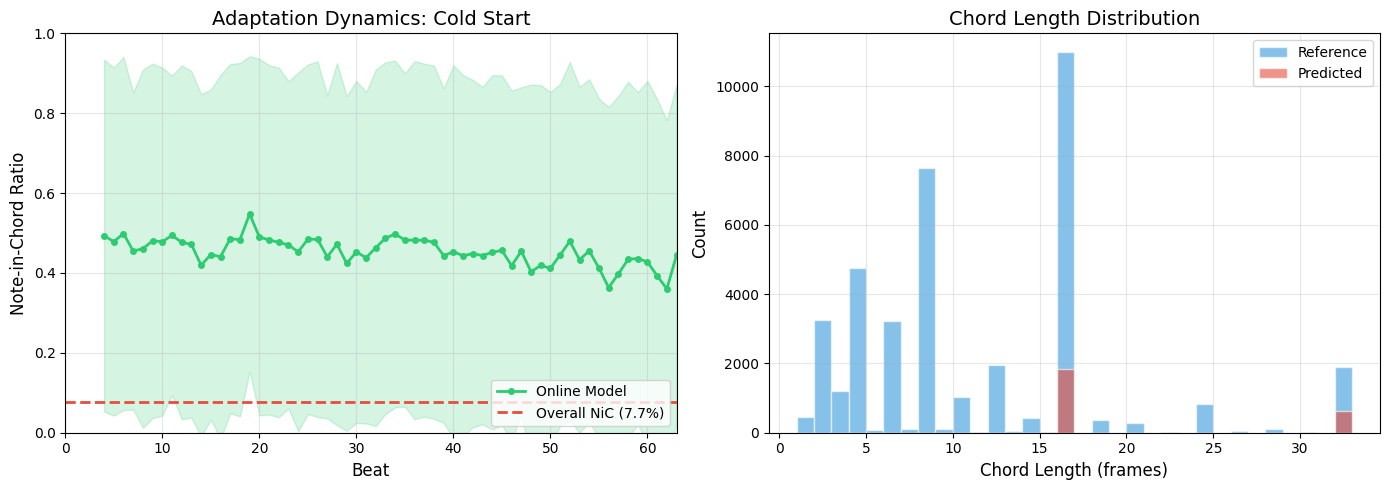

In [10]:
plt.figure(figsize=(14, 5))

# Adaptation dynamics (Figure 4 style)
plt.subplot(1, 2, 1)
if valid_beats:
    plt.plot(valid_beats, beat_means, 'o-', color='#2ecc71', linewidth=2, markersize=4, label='Online Model')
    plt.fill_between(
        valid_beats,
        [m - s for m, s in zip(beat_means, beat_stds)],
        [m + s for m, s in zip(beat_means, beat_stds)],
        alpha=0.2, color='#2ecc71'
    )
plt.axhline(y=avg_nic, color='#e74c3c', linestyle='--', linewidth=2, label=f'Overall NiC ({avg_nic:.1%})')
plt.xlabel('Beat', fontsize=12)
plt.ylabel('Note-in-Chord Ratio', fontsize=12)
plt.title('Adaptation Dynamics: Cold Start', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.xlim(0, max(valid_beats) if valid_beats else 32)

# Chord length histogram
plt.subplot(1, 2, 2)
max_len = 32
pred_hist = [min(length, max_len) for length in all_pred_lengths]
ref_hist = [min(length, max_len) for length in all_ref_lengths]

plt.hist(ref_hist, bins=range(1, max_len + 2), alpha=0.6, label='Reference', color='#3498db', edgecolor='white')
plt.hist(pred_hist, bins=range(1, max_len + 2), alpha=0.6, label='Predicted', color='#e74c3c', edgecolor='white')
plt.xlabel('Chord Length (frames)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Chord Length Distribution', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [11]:
def show_example(idx: int, max_frames: int = 48):
    """Display a single example generation using cached predictions."""
    if idx not in cached_predictions:
        print(f"⚠ Example {idx} not in cache. Skipping.")
        return

    mel_tokens, pred_tokens, ref_tokens = cached_predictions[idx]
    nic = note_in_chord_ratio(mel_tokens, pred_tokens)

    def format_tokens(tokens, max_n):
        """Format tokens for display, filtering special tokens."""
        filtered = [t for t in tokens[:max_n] if not t.startswith('<')]
        if not filtered:
            return "(all rest/special tokens)"
        # Simplify display: remove _on/_hold suffixes, compress holds
        display = []
        for t in filtered:
            if t.endswith('_hold') and display and display[-1] == '...':
                continue
            elif t.endswith('_hold'):
                display.append('...')
            else:
                display.append(t.replace('_on', ''))
        return ' '.join(display[:24])  # Limit width

    print(f"\n{'='*70}")
    print(f"Example {idx} | NiC: {nic:.1%} | Frames: {len(mel_tokens)}")
    print(f"{'='*70}")
    print(f"\nMelody:")
    print(format_tokens(mel_tokens, max_frames))
    print(f"\nPredicted Chords:")
    print(format_tokens(pred_tokens, max_frames))
    print(f"\nReference Chords:")
    print(format_tokens(ref_tokens, max_frames))

# Show examples: best, median, worst by NiC
if cached_predictions:
    sorted_by_nic = sorted(
        cached_predictions.keys(),
        key=lambda idx: note_in_chord_ratio(
            cached_predictions[idx][0], cached_predictions[idx][1]
        ),
        reverse=True
    )

    print("Showing examples by NiC quality (best, median, worst):")
    show_example(sorted_by_nic[0])  # Best
    show_example(sorted_by_nic[len(sorted_by_nic) // 2])  # Median
    show_example(sorted_by_nic[-1])  # Worst


Showing examples by NiC quality (best, median, worst):

Example 1707 | NiC: 100.0% | Frames: 256

Melody:
rest rest rest rest rest rest rest rest pitch_44 ... pitch_44 ... rest rest rest rest rest rest rest rest pitch_44 ... rest rest

Predicted Chords:
rest rest rest rest rest rest rest rest rest rest rest rest rest rest rest rest Ab:3-4/0 ...

Reference Chords:
Ab:3-4/0 ... rest rest rest rest rest rest rest rest rest rest rest rest Ab:3-4/0 ... rest rest rest rest rest rest rest rest

Example 1148 | NiC: 0.0% | Frames: 128

Melody:
pitch_65 ... pitch_67 ... pitch_67 ... rest rest rest rest rest rest rest rest rest rest rest rest rest rest rest rest rest rest

Predicted Chords:
rest rest rest rest rest rest rest rest rest rest rest rest rest rest rest rest rest rest rest rest rest rest rest rest

Reference Chords:
Ab:4-3/0 ... C:3-4/0 ...

Example 2759 | NiC: 0.0% | Frames: 128

Melody:
pitch_72 ... pitch_70 ... pitch_70 ... pitch_67 ... pitch_70 ... pitch_72 ... rest rest rest rest 

### Documentation of `YvCPBNkFS9OS` (Evaluation Metrics and Adaptation Dynamics)

#### Current Status:
This cell now robustly handles cases where `test_ds[sample_idx]` returns string tokens for melody by explicitly converting them to numerical IDs and dealing with unknown tokens or empty sequences. This resolved the `TypeError` and `KeyError` previously encountered.

#### Observations/Potential Improvements:
1.  **Commented-out Diagnostic Prints:** The warning `print` statements for `Unknown melody token` or `Melody sequence... is empty` are currently commented out. While the code now gracefully handles these cases, uncommenting them could provide valuable insights into data quality or unexpected token distributions during evaluation runs.
2.  **`Computed dynamics for beats 0-0` Output:** The output `Computed dynamics for beats 0-0` suggests that for many samples, there might not be enough valid beats (i.e., `len(beat_nic_all[beat]) > 5`) to compute meaningful means and standard deviations for the adaptation dynamics plot. This could be due to:
    *   Very short melodies/chord sequences in the test set.
    *   A high proportion of samples starting with padding or rest tokens, leading to an empty `melody_frames` after stripping special tokens.
    This isn't an error, but it limits the effectiveness of the adaptation dynamics visualization for this particular dataset or model's generation behavior. You might want to review the `MAX_BEATS` or the filtering condition `len(beat_nic_all[beat]) > 5` if you expect more beats to be analyzed.

### Documentation of `ycO1AO58S9OS` (Function `show_example`)

#### Current Status:
This cell's `show_example` function now correctly converts both melody (`src`) and reference chord (`tgt`) string tokens into numerical IDs, handles unknown tokens by mapping them to padding, and gracefully skips empty melody sequences. This resolved the `AttributeError`, `KeyError`, and `TypeError` previously encountered.

#### Observations/Potential Improvements:
1.  **Inconsistent Token Filtering for Display:**
    *   The `Melody` output directly prints `mel_tokens[:max_tokens]`, which can include special tokens like `<pad>`. For example, `Melody (first 32 frames): <pad> <pad>`.
    *   The `Reference Chords` output uses `ref_filtered = [t for t in ref_tokens[:max_tokens] if not t.startswith('<')]`, explicitly filtering out special tokens.
    This inconsistency can make comparison harder if special tokens in the melody are not desired. You might consider applying similar filtering to `mel_tokens` if you only want to display actual musical events.
2.  **Empty Reference Chords Display:** For some examples (e.g., Examples 0, 50, 100 in the provided output), the "Reference Chords" section appears empty. This happens because all tokens in `ref_tokens[:max_tokens]` are special tokens (like `<sos>`, `<eos>`, `<pad>`) which are filtered out by `not t.startswith('<')`. This behavior is correct if you only want to see non-special musical tokens, but it might be misleading if the reference sequence was, for example, a long 'rest' represented by special tokens, and it's not explicitly shown.
3.  **Verbose Padding in Melody Display:** If a melody sequence is very short or consists mainly of padding, the output can be dominated by `<pad>` tokens, as seen in the provided examples. Depending on the desired clarity, further processing of `mel_tokens` (e.g., removing leading/trailing `<pad>` tokens) could make the output more concise.